In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import time
from tqdm import tqdm # Direct import
import matplotlib.pyplot as plt
from data_loader import get_cifar100_loaders
from evaluation_utils import (evaluate_model, plot_confusion_matrix,
                              visualize_misclassified, get_cifar100_class_names)

In [17]:
def train_model(model, train_loader, test_loader, num_epochs, learning_rate, device, model_name="densenet121"):
    criterion = nn.CrossEntropyLoss()

    # Adam or SGD can work for DenseNet; Adam is often a good starting point for fine-tuning.
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) # Add some weight decay
    # Consider a learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    model.to(device)
    best_accuracy = 0.0
    model_save_path = f'{model_name}_cifar100_best.pth'

    train_acc_history = []
    test_acc_history = []
    val_loss_history = [] # For ReduceLROnPlateau

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for i, (inputs, labels) in enumerate(train_iterator):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            train_iterator.set_postfix(loss=loss.item())

        epoch_loss_train = running_loss / len(train_loader.dataset)
        epoch_acc_train = 100.0 * correct_train / total_train
        train_acc_history.append(epoch_acc_train)

        # Validation
        model.eval()
        running_val_loss = 0.0
        correct_test = 0
        total_test = 0
        test_iterator = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for inputs, labels in test_iterator:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss_batch = criterion(outputs, labels) # Calculate validation loss per batch
                running_val_loss += val_loss_batch.item() * inputs.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / len(test_loader.dataset)
        val_loss_history.append(epoch_val_loss)
        epoch_acc_test = 100.0 * correct_test / total_test
        test_acc_history.append(epoch_acc_test)
        end_time = time.time()
        epoch_duration = end_time - start_time

        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_loss_train:.4f} | Train Acc: {epoch_acc_train:.2f}% | '
              f'Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_acc_test:.2f}% | ' # Changed "Test" to "Val"
              f'LR: {optimizer.param_groups[0]["lr"]:.6f} | ' # Get LR from optimizer
              f'Duration: {epoch_duration:.2f}s')

        # Step the scheduler with validation loss
        scheduler.step(epoch_val_loss)

        # Save best model based on validation accuracy
        if epoch_acc_test > best_accuracy:
            best_accuracy = epoch_acc_test
            try:
                torch.save(model.state_dict(), model_save_path)
                print(f'>>> Best model saved to {model_save_path} with Val Accuracy: {best_accuracy:.2f}%')
            except Exception as e:
                 print(f"Lỗi khi lưu model: {e}")

    print('Finished Training')
    print(f'Best Validation Accuracy achieved during training: {best_accuracy:.2f}%')

    print(f"Loading best model state from {model_save_path} for final evaluation...")
    try:
        model.load_state_dict(torch.load(model_save_path))
    except Exception as e:
        print(f"Could not load best model state: {e}. Evaluating with the final model state.")

    return model, train_acc_history, test_acc_history


Sử dụng thiết bị: cuda
Đang tải dữ liệu CIFAR-100 (resize: 224x224)...
Đã tải xong CIFAR-100.
Số lượng ảnh Train: 50000
Số lượng ảnh Test: 10000
Kích thước ảnh: 224x224
Sử dụng Data Augmentation: True
Khởi tạo 4_DENSENET121 pre-trained model...
Đã thay thế lớp classifier của DenseNet121 bằng lớp Linear(1024, 100)
Bắt đầu fine-tuning 4_DENSENET121...


Epoch 1/20 [Val]: 100%|██████████| 1250/1250 [00:29<00:00, 43.10it/s]


Epoch 1/20 | Train Loss: 4.5291 | Train Acc: 2.66% | Val Loss: 4.2028 | Val Acc: 5.56% | LR: 0.001000 | Duration: 638.76s
>>> Best model saved to 4_DenseNet121_cifar100_best.pth with Val Accuracy: 5.56%


Epoch 2/20 [Val]: 100%|██████████| 1250/1250 [00:28<00:00, 43.89it/s]


Epoch 2/20 | Train Loss: 4.2116 | Train Acc: 5.87% | Val Loss: 3.8209 | Val Acc: 11.54% | LR: 0.001000 | Duration: 637.10s
>>> Best model saved to 4_DenseNet121_cifar100_best.pth with Val Accuracy: 11.54%


Epoch 3/20 [Val]: 100%|██████████| 1250/1250 [00:28<00:00, 43.51it/s]


Epoch 3/20 | Train Loss: 4.0220 | Train Acc: 8.69% | Val Loss: 3.4671 | Val Acc: 17.06% | LR: 0.001000 | Duration: 643.99s
>>> Best model saved to 4_DenseNet121_cifar100_best.pth with Val Accuracy: 17.06%


Epoch 4/20 [Val]: 100%|██████████| 1250/1250 [00:28<00:00, 44.60it/s]


Epoch 4/20 | Train Loss: 3.7814 | Train Acc: 12.49% | Val Loss: 3.2458 | Val Acc: 22.16% | LR: 0.001000 | Duration: 638.30s
>>> Best model saved to 4_DenseNet121_cifar100_best.pth with Val Accuracy: 22.16%


Epoch 5/20 [Val]: 100%|██████████| 1250/1250 [00:28<00:00, 44.04it/s]


Epoch 5/20 | Train Loss: 3.5986 | Train Acc: 15.45% | Val Loss: 2.9282 | Val Acc: 27.64% | LR: 0.001000 | Duration: 646.85s
>>> Best model saved to 4_DenseNet121_cifar100_best.pth with Val Accuracy: 27.64%


Epoch 6/20 [Val]: 100%|██████████| 1250/1250 [00:28<00:00, 43.24it/s]


Epoch 6/20 | Train Loss: 3.4663 | Train Acc: 17.36% | Val Loss: 3.0149 | Val Acc: 27.31% | LR: 0.001000 | Duration: 617.98s


Epoch 7/20 [Val]: 100%|██████████| 1250/1250 [00:28<00:00, 43.25it/s]


Epoch 7/20 | Train Loss: 3.3732 | Train Acc: 19.54% | Val Loss: 2.6647 | Val Acc: 31.84% | LR: 0.001000 | Duration: 629.70s
>>> Best model saved to 4_DenseNet121_cifar100_best.pth with Val Accuracy: 31.84%


Epoch 8/20 [Val]: 100%|██████████| 1250/1250 [00:28<00:00, 43.14it/s]


Epoch 8/20 | Train Loss: 3.2771 | Train Acc: 21.24% | Val Loss: 2.6672 | Val Acc: 33.07% | LR: 0.001000 | Duration: 638.33s
>>> Best model saved to 4_DenseNet121_cifar100_best.pth with Val Accuracy: 33.07%


Epoch 9/20 [Val]: 100%|██████████| 1250/1250 [00:28<00:00, 44.20it/s]


Epoch 9/20 | Train Loss: 3.1994 | Train Acc: 22.64% | Val Loss: 2.5702 | Val Acc: 35.57% | LR: 0.001000 | Duration: 635.66s
>>> Best model saved to 4_DenseNet121_cifar100_best.pth with Val Accuracy: 35.57%


Epoch 10/20 [Val]: 100%|██████████| 1250/1250 [00:28<00:00, 43.68it/s]


Epoch 10/20 | Train Loss: 3.1281 | Train Acc: 24.08% | Val Loss: 2.4883 | Val Acc: 36.64% | LR: 0.001000 | Duration: 652.23s
>>> Best model saved to 4_DenseNet121_cifar100_best.pth with Val Accuracy: 36.64%


Epoch 11/20 [Val]: 100%|██████████| 1250/1250 [00:28<00:00, 43.31it/s]


Epoch 11/20 | Train Loss: 3.0658 | Train Acc: 25.17% | Val Loss: 2.3144 | Val Acc: 40.67% | LR: 0.001000 | Duration: 633.89s
>>> Best model saved to 4_DenseNet121_cifar100_best.pth with Val Accuracy: 40.67%


Epoch 12/20 [Val]: 100%|██████████| 1250/1250 [00:28<00:00, 43.83it/s]


Epoch 12/20 | Train Loss: 3.0105 | Train Acc: 26.39% | Val Loss: 2.4086 | Val Acc: 39.19% | LR: 0.001000 | Duration: 630.87s


Epoch 13/20 [Val]: 100%|██████████| 1250/1250 [00:28<00:00, 43.55it/s]


Epoch 13/20 | Train Loss: 2.9835 | Train Acc: 26.91% | Val Loss: 2.3226 | Val Acc: 41.69% | LR: 0.001000 | Duration: 625.52s
>>> Best model saved to 4_DenseNet121_cifar100_best.pth with Val Accuracy: 41.69%


Epoch 14/20 [Val]: 100%|██████████| 1250/1250 [00:29<00:00, 42.06it/s]


Epoch 14/20 | Train Loss: 2.9524 | Train Acc: 27.41% | Val Loss: 2.2053 | Val Acc: 43.03% | LR: 0.001000 | Duration: 679.24s
>>> Best model saved to 4_DenseNet121_cifar100_best.pth with Val Accuracy: 43.03%


Epoch 15/20 [Val]: 100%|██████████| 1250/1250 [00:29<00:00, 42.97it/s]


Epoch 15/20 | Train Loss: 2.9148 | Train Acc: 28.29% | Val Loss: 2.2689 | Val Acc: 42.68% | LR: 0.001000 | Duration: 659.57s


Epoch 16/20 [Val]: 100%|██████████| 1250/1250 [00:28<00:00, 44.12it/s]


Epoch 16/20 | Train Loss: 2.8777 | Train Acc: 28.84% | Val Loss: 2.2267 | Val Acc: 42.92% | LR: 0.001000 | Duration: 664.56s


Epoch 17/20 [Val]: 100%|██████████| 1250/1250 [00:28<00:00, 44.01it/s]


Epoch 17/20 | Train Loss: 2.8561 | Train Acc: 29.54% | Val Loss: 2.2704 | Val Acc: 42.90% | LR: 0.001000 | Duration: 659.02s


Epoch 18/20 [Val]: 100%|██████████| 1250/1250 [00:28<00:00, 43.96it/s]


Epoch 18/20 | Train Loss: 2.8303 | Train Acc: 30.08% | Val Loss: 2.1491 | Val Acc: 45.15% | LR: 0.001000 | Duration: 644.49s
>>> Best model saved to 4_DenseNet121_cifar100_best.pth with Val Accuracy: 45.15%


Epoch 19/20 [Val]: 100%|██████████| 1250/1250 [00:28<00:00, 44.30it/s]


Epoch 19/20 | Train Loss: 2.8007 | Train Acc: 30.57% | Val Loss: 2.2302 | Val Acc: 43.81% | LR: 0.001000 | Duration: 673.25s


Epoch 20/20 [Val]: 100%|██████████| 1250/1250 [00:27<00:00, 45.80it/s]


Epoch 20/20 | Train Loss: 2.7858 | Train Acc: 30.73% | Val Loss: 2.1691 | Val Acc: 44.95% | LR: 0.001000 | Duration: 652.56s
Finished Training
Best Validation Accuracy achieved during training: 45.15%
Loading best model state from 4_DenseNet121_cifar100_best.pth for final evaluation...

--- Performing Final Evaluation on Test Set for 4_DENSENET121 ---
Evaluating on test set...


  0%|          | 0/1250 [00:00<?, ?it/s]


Classification Report:
               precision    recall  f1-score   support

        apple       0.56      0.80      0.66       100
aquarium_fish       0.60      0.57      0.58       100
         baby       0.56      0.19      0.28       100
         bear       0.20      0.09      0.12       100
       beaver       0.60      0.03      0.06       100
          bed       0.41      0.44      0.43       100
          bee       0.60      0.26      0.36       100
       beetle       0.46      0.38      0.42       100
      bicycle       0.81      0.50      0.62       100
       bottle       0.66      0.60      0.63       100
         bowl       0.58      0.14      0.23       100
          boy       0.59      0.17      0.26       100
       bridge       0.41      0.58      0.48       100
          bus       0.36      0.35      0.36       100
    butterfly       0.41      0.35      0.38       100
        camel       0.49      0.30      0.37       100
          can       0.47      0.64      

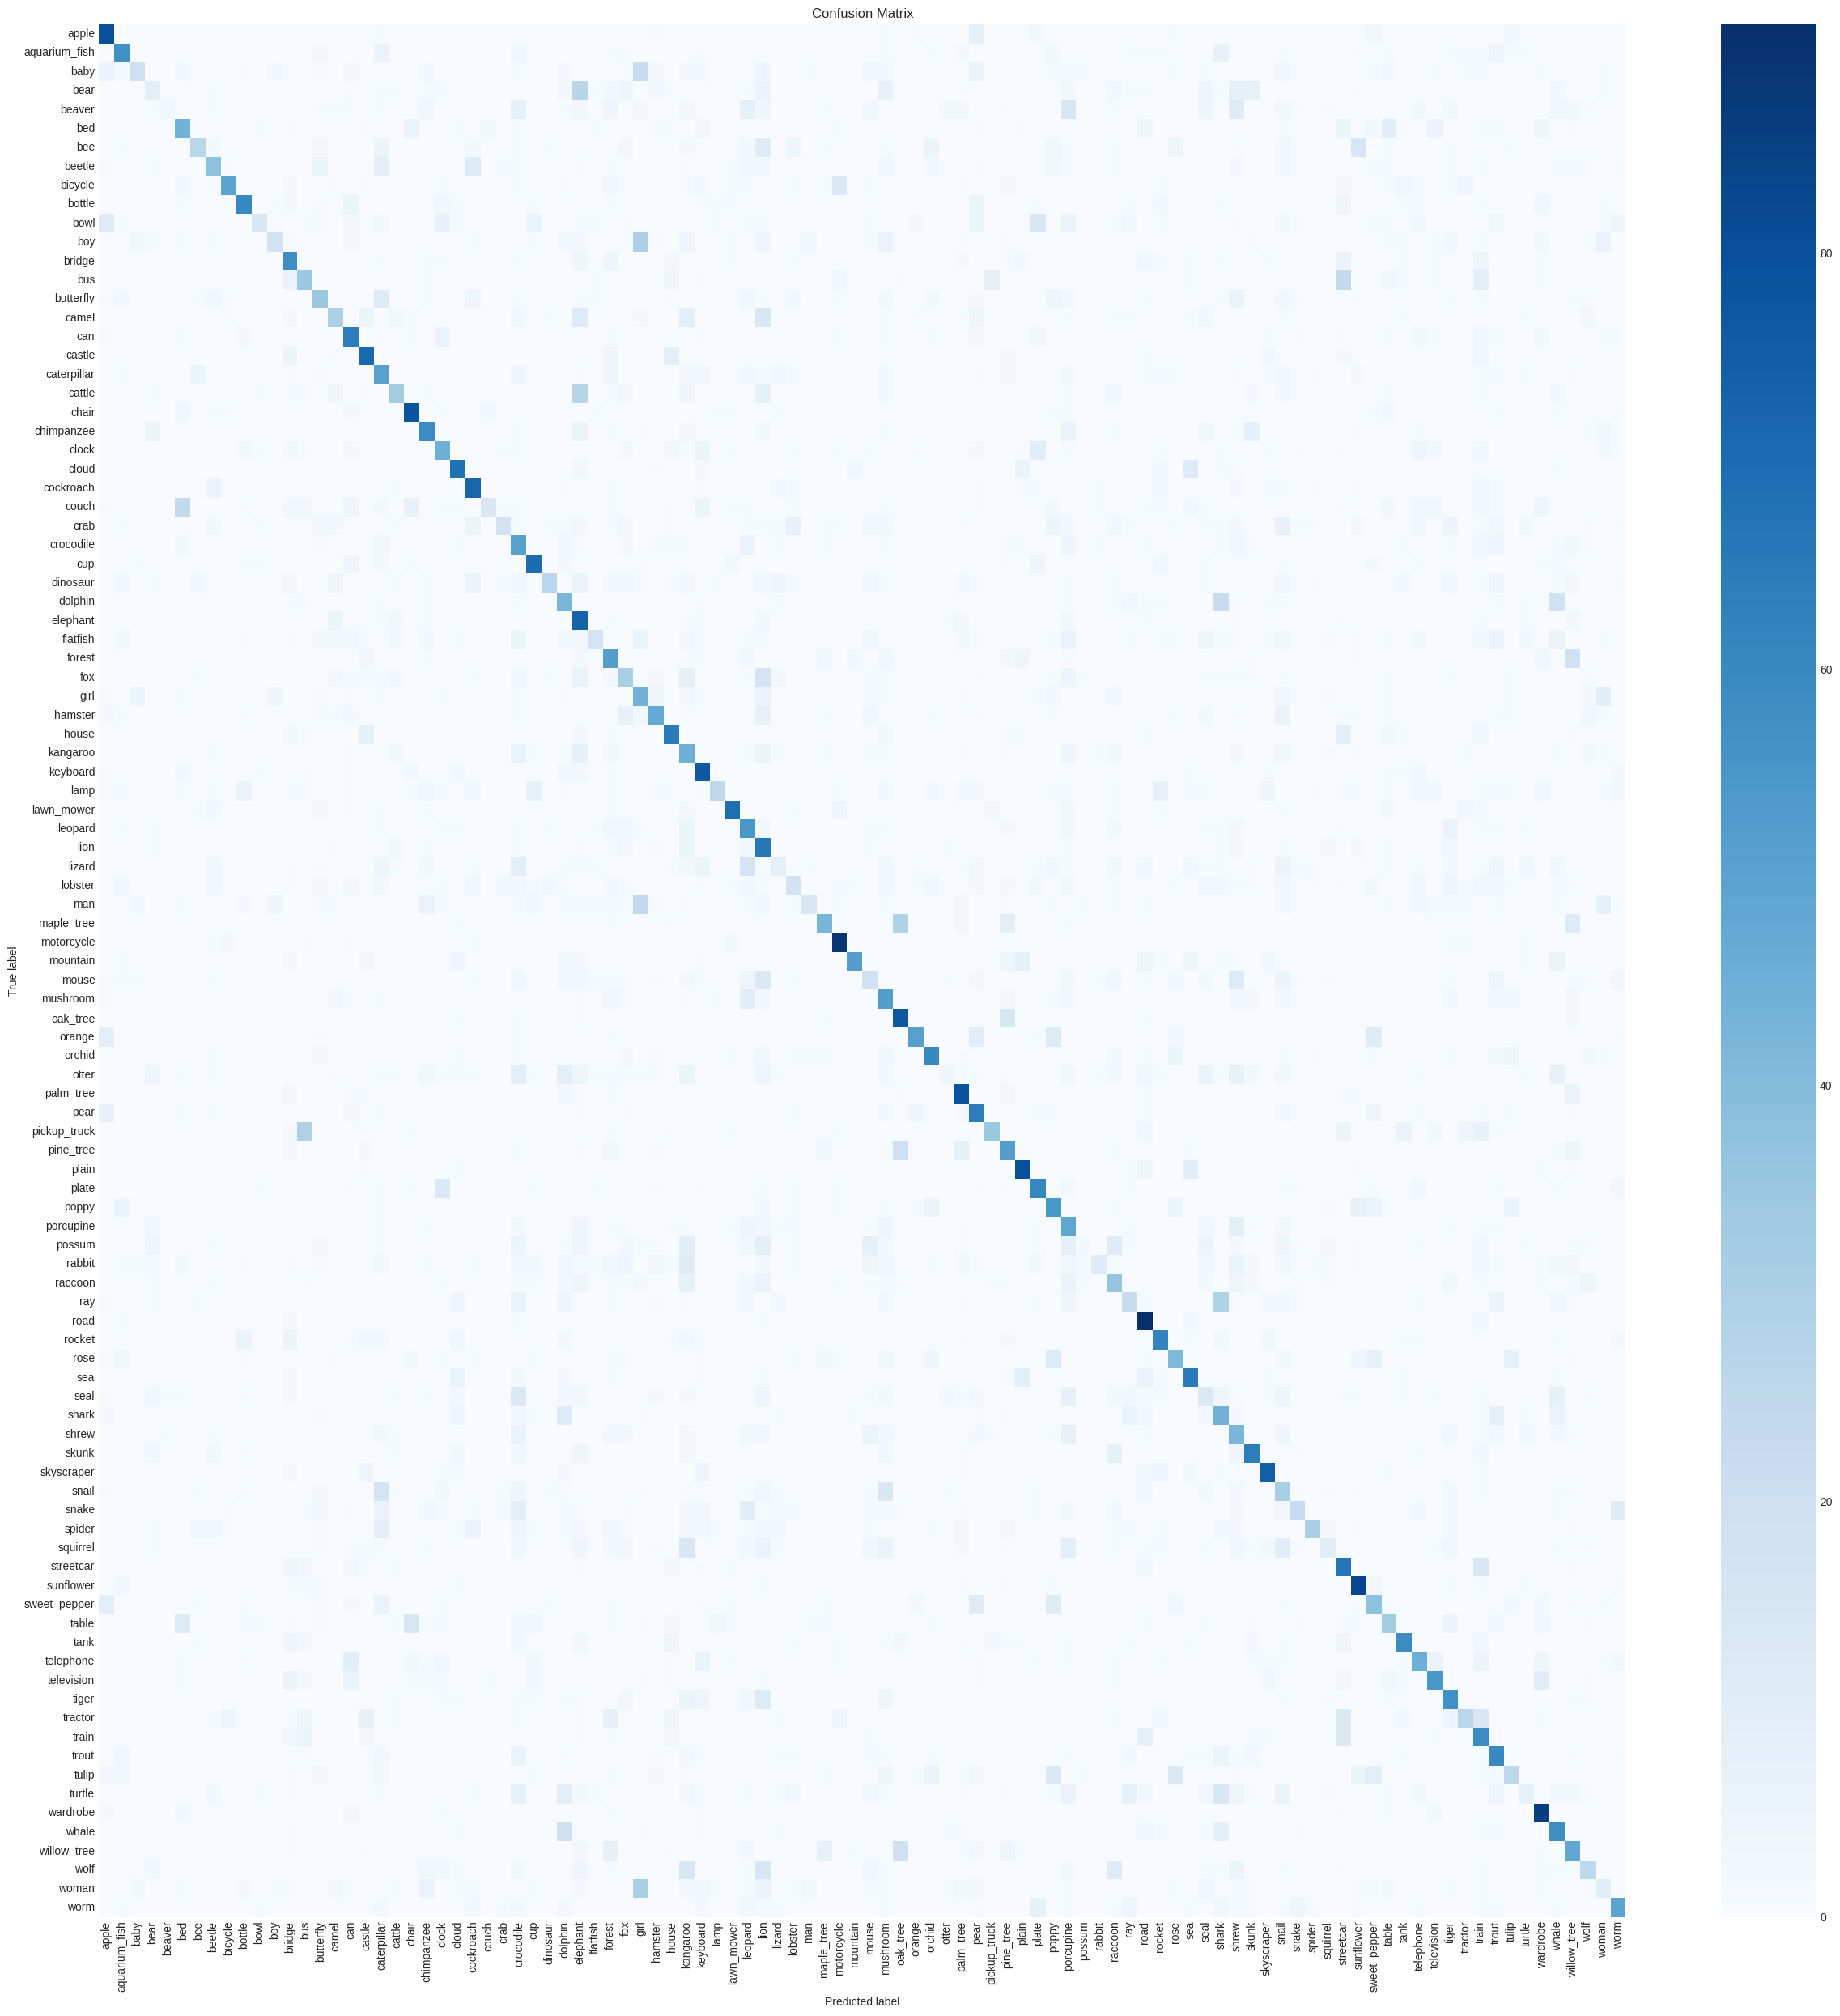


Searching for 25 misclassified images...


  0%|          | 0/1250 [00:00<?, ?it/s]

Visualizing 25 misclassified images...
Misclassified images visualization saved to 4_DenseNet121_misclassified_25.png


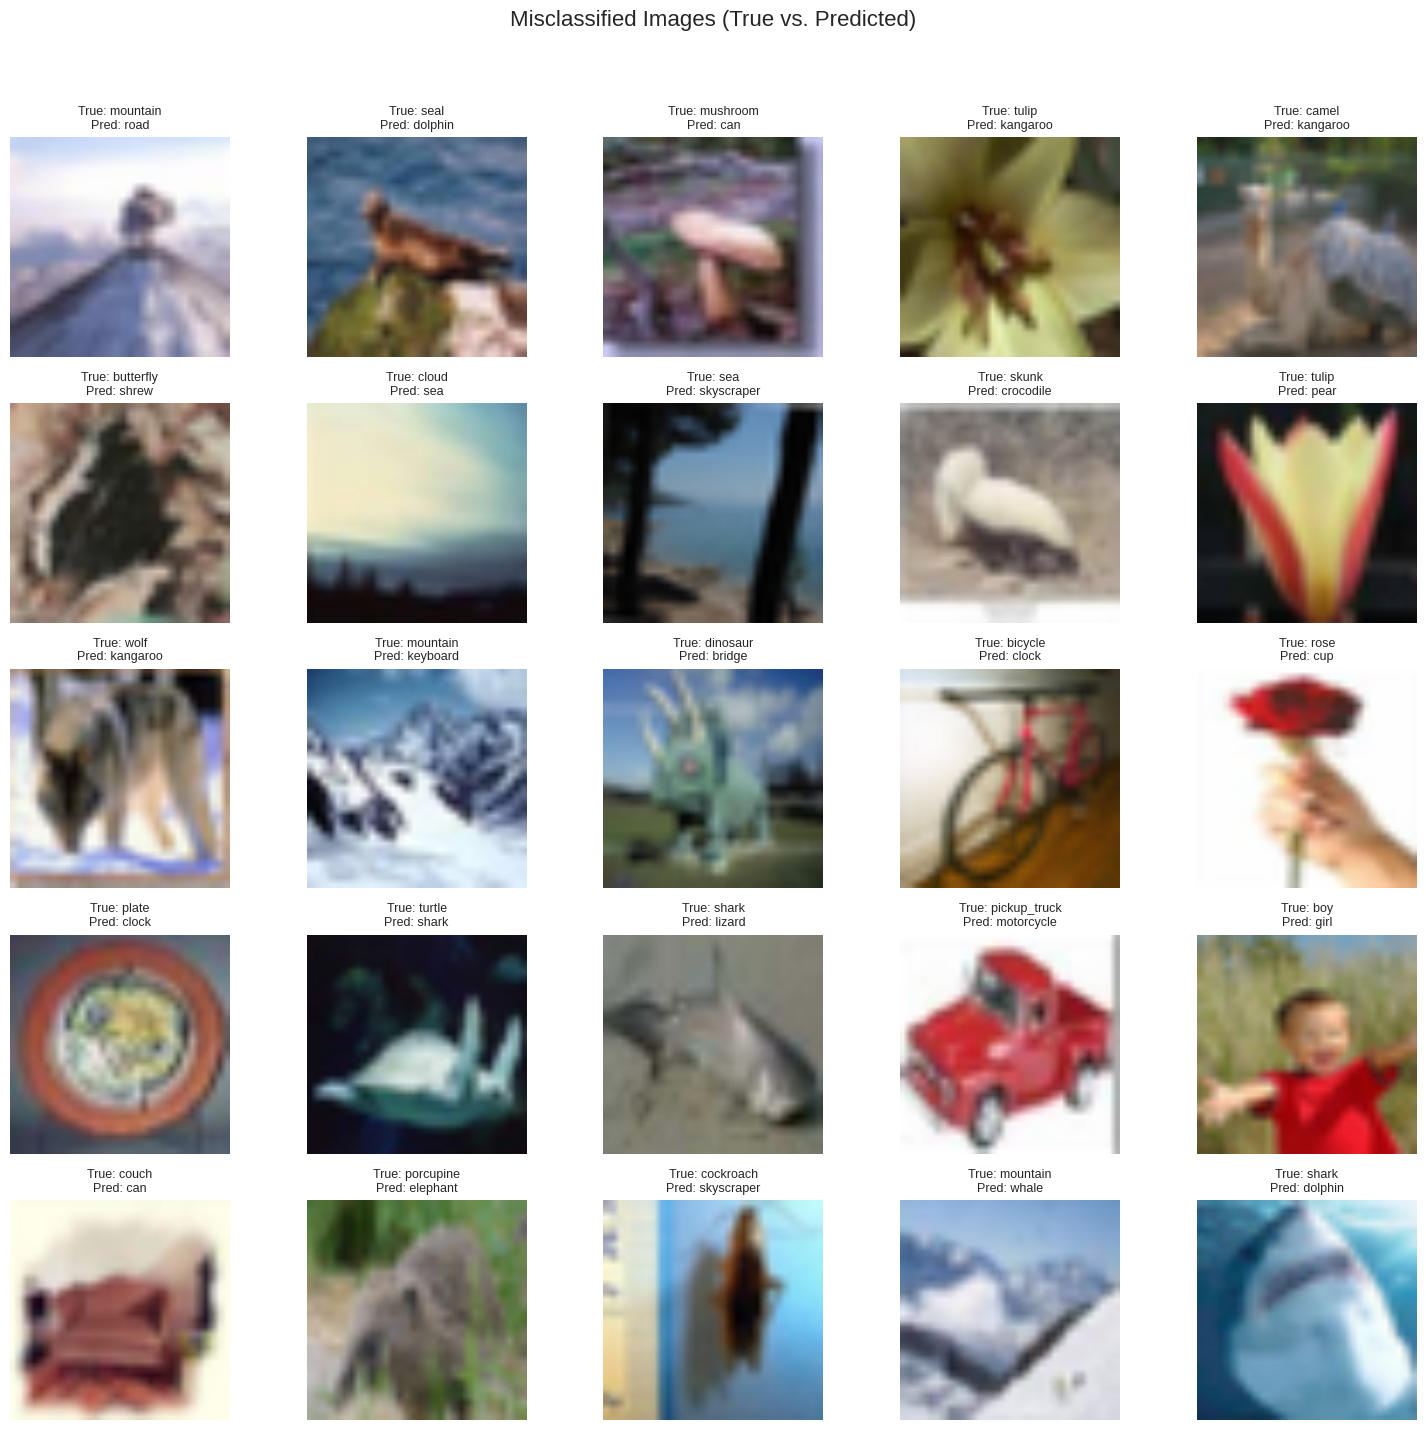

Accuracy history plot saved to 4_DenseNet121_accuracy_history.png


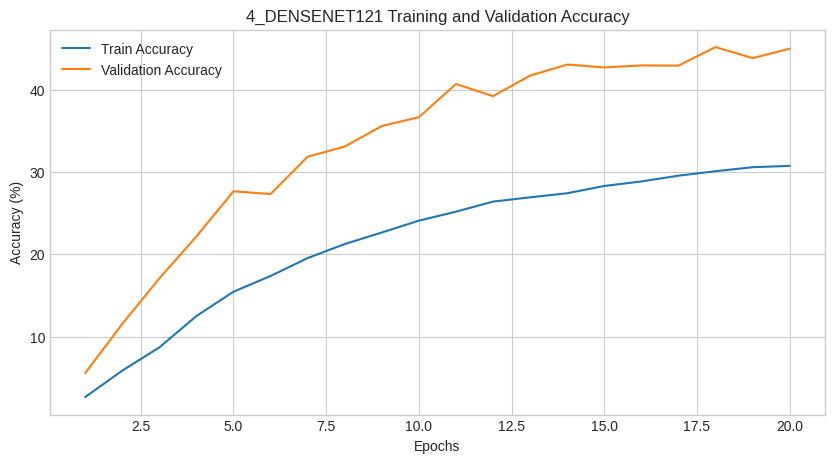

In [18]:
NUM_EPOCHS = 20         # As per previous request
BATCH_SIZE = 8
LEARNING_RATE = 0.001
IMG_SIZE = 224          # DenseNet pre-trained models also expect 224x224
USE_AUGMENTATION = True
DATA_DIR = './data_cifar100'
NUM_WORKERS = 4
MODEL_NAME = "4_DenseNet121"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

torch.cuda.empty_cache()

class_names = get_cifar100_class_names(DATA_DIR)
num_classes = len(class_names)

print(f"Đang tải dữ liệu CIFAR-100 (resize: {IMG_SIZE}x{IMG_SIZE})...")
train_loader, test_loader, _ = get_cifar100_loaders(
    batch_size=BATCH_SIZE,
    data_dir=DATA_DIR,
    img_size=IMG_SIZE,
    use_augmentation=USE_AUGMENTATION,
    num_workers=NUM_WORKERS
)

if train_loader is None:
    print("Không thể tải dữ liệu. Kết thúc chương trình.")
    exit()

print(f"Khởi tạo {MODEL_NAME.upper()} pre-trained model...")
# --- Load DenseNet121 with pre-trained weights ---
weights = models.DenseNet121_Weights.IMAGENET1K_V1
model = models.densenet121(weights=weights)
# Or older: model = models.densenet121(pretrained=True)

# --- Modify the classifier for CIFAR-100 ---
# DenseNet's classifier is a single nn.Linear layer
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, num_classes)
print(f"Đã thay thế lớp classifier của DenseNet121 bằng lớp Linear({num_ftrs}, {num_classes})")

print(f"Bắt đầu fine-tuning {MODEL_NAME.upper()}...")
trained_model, train_history, test_history = train_model(
    model, train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, device, model_name=MODEL_NAME
)

# --- Final Evaluation and Visualization ---
print(f"\n--- Performing Final Evaluation on Test Set for {MODEL_NAME.upper()} ---")
final_metrics = evaluate_model(trained_model, test_loader, device, num_classes, class_names)

if 'confusion_matrix' in final_metrics:
    plot_confusion_matrix(final_metrics['confusion_matrix'], class_names,
                            filename=f'{MODEL_NAME}_confusion_matrix.png',
                            figsize=(25, 25))

visualize_misclassified(trained_model, test_loader, device, class_names,
                        num_images=25,
                        filename_prefix=f'{MODEL_NAME}_misclassified')

plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_history, label='Train Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), test_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title(f'{MODEL_NAME.upper()} Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(f'{MODEL_NAME}_accuracy_history.png')
print(f"Accuracy history plot saved to {MODEL_NAME}_accuracy_history.png")
plt.show()
